# CSGY 6953 Deep Learning Final Project
In this project, we will implement a dual-encoder model for image search. Our model will be trained so that it embeds both images and texts into the same space, and importantly, maps relevant data to be close each other in the embedding space. This will be done by developing two encoders, one for image processing and the other for text encoding, and training them by a similarity-based loss function.<br>
<br>
In this note book, we investigate the use of GloVe instead of BERT for our text encoder.

## 1. Preparation
As always, prepare the dataset for the training.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open(f"drive/My Drive/finalproj/data/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)

In [ ]:
# Split them into training and test sets.
train_pct = 0.7
threshold = int(len(dataset["images"]) * train_pct)
train_images = dataset["images"][:threshold]
train_texts = dataset["texts"][:threshold * 10]
test_images = dataset["images"][threshold:]
test_texts = dataset["texts"][threshold * 10:]
print(f"Training images: ", len(train_images))
print(f"Training texts: ", len(train_texts))
print(f"Test images: ", len(test_images))
print(f"Test texts: ", len(test_texts))

Training images:  3150
Training texts:  31500
Test images:  1350
Test texts:  13500


In [ ]:
import torch
from torch.utils.data import DataLoader

In [ ]:
# These are the libraries we developed from scratch for this project.
sys.path.append("drive/My Drive/finalproj")
import EncoderHeads, Dataset, utils

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The device is " + device.type + ".")

The device is cuda.


In [ ]:
embed_dim = 256
max_len = 46 # Recommend: 46 for GloVe, 60 for BERT (though the maximum is 146)
image_encoder_model = "InceptionV3"
text_encoder_model = "GloVe"
image_head_model = "FC"
text_head_model = "BiLSTM"

TrainingDataset = Dataset.DualEncoderDataset(train_images, train_texts, device, image_encoder_model, text_encoder_model, max_len=max_len, neg_rate=4)
TestDataset = Dataset.DualEncoderDataset(test_images, test_texts, device, image_encoder_model, text_encoder_model, max_len=max_len, neg_rate=4)
TrainingDataset.print_num_params()


Preprocessing image data...


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

100%|██████████| 99/99 [00:20<00:00,  4.93it/s]


Preprocessing text data...


.vector_cache/glove.6B.zip: 862MB [02:40, 5.39MB/s]                           
100%|██████████| 985/985 [00:12<00:00, 78.66it/s] 



Preprocessing image data...


100%|██████████| 43/43 [00:05<00:00,  7.40it/s]


Preprocessing text data...


100%|██████████| 422/422 [00:06<00:00, 60.65it/s]



=== Image Encoder ===
  Pretrained Parameters: 25,112,264

=== Text Encoder ===
  Pretrained Parameters: 0


In [ ]:
epochs = 20
batch_size = 128
train_loss = []
eval_loss = []
trainloader = DataLoader(TrainingDataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(TestDataset, batch_size=batch_size, shuffle=True)

image_head = EncoderHeads.EncoderHead(image_head_model, TrainingDataset.image_encoder_output_size, embed_dim).to(device)
text_head = EncoderHeads.EncoderHead(text_head_model, TrainingDataset.text_encoder_output_size, embed_dim).to(device)
print(f"=== Image Encoder Head ===")
print(f"  Trainable Parameters: {image_head.num_parameters:,}")
print(f"\n=== Text Encoder Head ===")
print(f"  Trainable Parameters: {text_head.num_parameters:,}")

criterion = torch.nn.CosineEmbeddingLoss(margin=0.1, reduction='sum') # Recipe 1M+ paper sets margin=0.1.
image_optimizer = torch.optim.Adam(image_head.parameters(), lr=0.0005)
text_optimizer = torch.optim.Adam(text_head.parameters(), lr=0.0005)

=== Image Encoder Head ===
  Trainable Parameters: 1,180,416

=== Text Encoder Head ===
  Trainable Parameters: 319,456


## 2. First Attempt
The same as other models, train the model for 20 epochs and check the result.

In [ ]:
print("Start Training...")
for epoch in range(epochs):
    trainloss = utils.train(trainloader, image_head, text_head, image_optimizer, text_optimizer, criterion)
    train_loss.append(trainloss)
    evalloss, _ = utils.eval(testloader, image_head, text_head, criterion)
    eval_loss.append(evalloss)
    if (epoch + 1) % 2 == 0:
        print(f"Epoch: {epoch + 1} | Training loss: {trainloss:.4f} | Test loss: {evalloss:.4f}")

Start Training...
Epoch: 2 | Training loss: 0.1807 | Test loss: 0.1804
Epoch: 4 | Training loss: 0.1799 | Test loss: 0.1802
Epoch: 6 | Training loss: 0.1790 | Test loss: 0.1804
Epoch: 8 | Training loss: 0.1757 | Test loss: 0.1814
Epoch: 10 | Training loss: 0.1748 | Test loss: 0.1807
Epoch: 12 | Training loss: 0.1744 | Test loss: 0.1818
Epoch: 14 | Training loss: 0.1740 | Test loss: 0.1804
Epoch: 16 | Training loss: 0.1736 | Test loss: 0.1808
Epoch: 18 | Training loss: 0.1735 | Test loss: 0.1816
Epoch: 20 | Training loss: 0.1733 | Test loss: 0.1806


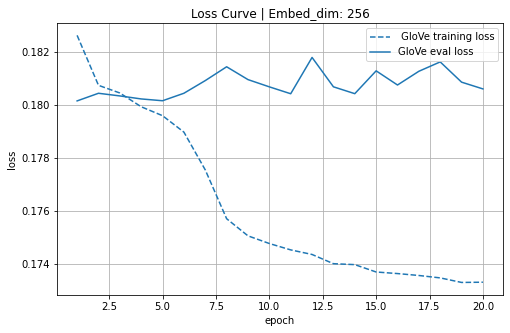

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, epochs + 1), train_loss, label=" GloVe training loss", color=plt.cm.tab10(0), linestyle="dashed")
plt.plot(np.arange(1, epochs + 1), eval_loss, label="GloVe eval loss", color=plt.cm.tab10(0))
plt.title(f"Loss Curve | Embed_dim: {embed_dim}")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()
plt.savefig("glove_first_attempt.png", bbox_inches="tight")
plt.show()

## 3. Modification
From the previous section, we saw that it takes so much time to train this model. This is partly because the model need to learn not only mapping but also language understanding. <br>
As our second attempt, we increase the learning rate only for text encoder and train more epochs.

In [ ]:
epochs = 50
batch_size = 128
train_loss = []
eval_loss = []
trainloader = DataLoader(TrainingDataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(TestDataset, batch_size=batch_size, shuffle=True)

image_head = EncoderHeads.EncoderHead(image_head_model, TrainingDataset.image_encoder_output_size, embed_dim).to(device)
text_head = EncoderHeads.EncoderHead(text_head_model, TrainingDataset.text_encoder_output_size, embed_dim).to(device)
print(f"=== Image Encoder Head ===")
print(f"  Trainable Parameters: {image_head.num_parameters:,}")
print(f"\n=== Text Encoder Head ===")
print(f"  Trainable Parameters: {text_head.num_parameters:,}")

criterion = torch.nn.CosineEmbeddingLoss(margin=0.1, reduction='sum') # Recipe 1M+ paper sets margin=0.1.
image_optimizer = torch.optim.Adam(image_head.parameters(), lr=0.0005)
text_optimizer = torch.optim.Adam(text_head.parameters(), lr=0.001)

=== Image Encoder Head ===
  Trainable Parameters: 1,180,416

=== Text Encoder Head ===
  Trainable Parameters: 319,456


In [ ]:
print("Start Training...")
for epoch in range(epochs):
    trainloss = utils.train(trainloader, image_head, text_head, image_optimizer, text_optimizer, criterion)
    train_loss.append(trainloss)
    evalloss, _ = utils.eval(testloader, image_head, text_head, criterion)
    eval_loss.append(evalloss)
    if (epoch + 1) % 2 == 0:
        print(f"Epoch: {epoch + 1} | Training loss: {trainloss:.4f} | Test loss: {evalloss:.4f}")

Start Training...
Epoch: 2 | Training loss: 0.1810 | Test loss: 0.1813
Epoch: 4 | Training loss: 0.1800 | Test loss: 0.1814
Epoch: 6 | Training loss: 0.1770 | Test loss: 0.1816
Epoch: 8 | Training loss: 0.1743 | Test loss: 0.1837
Epoch: 10 | Training loss: 0.1728 | Test loss: 0.1816
Epoch: 12 | Training loss: 0.1715 | Test loss: 0.1817
Epoch: 14 | Training loss: 0.1705 | Test loss: 0.1821
Epoch: 16 | Training loss: 0.1697 | Test loss: 0.1821
Epoch: 18 | Training loss: 0.1693 | Test loss: 0.1822
Epoch: 20 | Training loss: 0.1689 | Test loss: 0.1825
Epoch: 22 | Training loss: 0.1686 | Test loss: 0.1822
Epoch: 24 | Training loss: 0.1683 | Test loss: 0.1831
Epoch: 26 | Training loss: 0.1679 | Test loss: 0.1829
Epoch: 28 | Training loss: 0.1675 | Test loss: 0.1836
Epoch: 30 | Training loss: 0.1671 | Test loss: 0.1832
Epoch: 32 | Training loss: 0.1667 | Test loss: 0.1847
Epoch: 34 | Training loss: 0.1663 | Test loss: 0.1843
Epoch: 36 | Training loss: 0.1659 | Test loss: 0.1843
Epoch: 38 | Tr

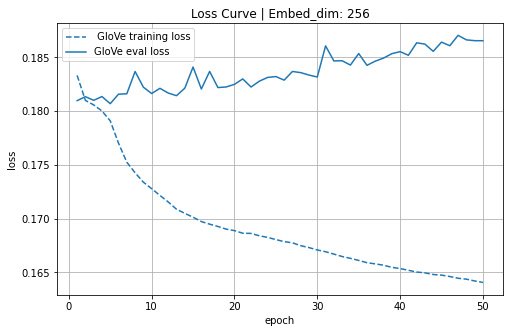

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, epochs + 1), train_loss, label=" GloVe training loss", color=plt.cm.tab10(0), linestyle="dashed")
plt.plot(np.arange(1, epochs + 1), eval_loss, label="GloVe eval loss", color=plt.cm.tab10(0))
plt.title(f"Loss Curve | Embed_dim: {embed_dim}")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()
plt.savefig("glove_second_attempt.png", bbox_inches="tight")
plt.show()

## 4. Training Only Text Encoder at First
As the text encoder need to learn how to extract semantic information from word embeddings, we first fix the image embeddings and train the text encoder. Next, freeze the text encoder and train the image encoder. Finally, let all the parameter trainable and train more epochs.

In [ ]:
# Create nearly orthogonal vectors.
num_images = trainloader.dataset.num_images
dummy_image = np.random.randint(0, 2, size=(num_images, embed_dim)) * 2 - 1
dummy_image = dummy_image.tolist()

# Set the dummy vectors as image data.
image_original = trainloader.dataset.imagedata_preprocessed
trainloader.dataset.imagedata_preprocessed = dummy_image

In [ ]:
epochs = 20
batch_size = 128
train_loss = []
eval_loss = []

image_head_model = "Identity"
text_head_model = "BiLSTM"

image_head = EncoderHeads.EncoderHead(image_head_model, TrainingDataset.image_encoder_output_size, embed_dim).to(device)
text_head = EncoderHeads.EncoderHead(text_head_model, TrainingDataset.text_encoder_output_size, embed_dim).to(device)
print(f"=== Image Encoder Head ===")
print(f"  Trainable Parameters: {image_head.num_parameters:,}")
print(f"\n=== Text Encoder Head ===")
print(f"  Trainable Parameters: {text_head.num_parameters:,}")

criterion = torch.nn.CosineEmbeddingLoss(margin=0.1, reduction='sum') # Recipe 1M+ paper sets margin=0.1.
text_optimizer = torch.optim.Adam(text_head.parameters(), lr=0.005)

=== Image Encoder Head ===
  Trainable Parameters: 0

=== Text Encoder Head ===
  Trainable Parameters: 319,456


In [ ]:
print("Start Training...")
for epoch in range(epochs):
    trainloss = utils.train(trainloader, image_head, text_head, None, text_optimizer, criterion, only_text=True)
    train_loss.append(trainloss)
    if (epoch + 1) % 2 == 0:
        print(f"Epoch: {epoch + 1} | Training loss: {trainloss:.4f}")

Start Training...
Epoch: 2 | Training loss: 0.1912
Epoch: 4 | Training loss: 0.1910
Epoch: 6 | Training loss: 0.1909


KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, epochs + 1), train_loss, label=" GloVe training loss", color=plt.cm.tab10(0), linestyle="dashed")
plt.title(f"Loss Curve | Embed_dim: {embed_dim}")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()
plt.savefig("glove_separate.png", bbox_inches="tight")
plt.show()

In [ ]:
# Insert back the original image data.
trainloader.dataset.imagedata_preprocessed = image_original
image_head_model = "FC"
image_head = EncoderHeads.EncoderHead(image_head_model, TrainingDataset.image_encoder_output_size, embed_dim).to(device)

# Freeze the text encoder parameters.
for params in text_head.parameters():
    params.required_grad = False

criterion = torch.nn.CosineEmbeddingLoss(margin=0.1, reduction='sum') # Recipe 1M+ paper sets margin=0.1.
image_optimizer = torch.optim.Adam(image_head.parameters(), lr=0.0005)
text_optimizer = torch.optim.Adam(text_head.parameters(), lr=0.0005)

In [ ]:
print("Start Training...")
for epoch in range(epochs):
    trainloss = utils.train(trainloader, image_head, text_head, image_optimizer, text_optimizer, criterion, only_image=True)
    train_loss.append(trainloss)
    evalloss, _ = utils.eval(testloader, image_head, text_head, criterion)
    eval_loss.append(evalloss)
    if (epoch + 1) % 2 == 0:
        print(f"Epoch: {epoch + 1} | Training loss: {trainloss:.4f} | Test loss: {evalloss:.4f}")

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, epochs * 2 + 1), train_loss, label=" GloVe training loss", color=plt.cm.tab10(0), linestyle="dashed")
plt.plot(np.arange(1, epochs * 2 + 1), eval_loss, label="GloVe eval loss", color=plt.cm.tab10(0))
plt.title(f"Loss Curve | Embed_dim: {embed_dim}")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()
plt.savefig("glove_separate.png", bbox_inches="tight")
plt.show()

In [ ]:
# Make the text encoder parameters trainable again.
for params in text_head.parameters():
    params.required_grad = True
criterion = torch.nn.CosineEmbeddingLoss(margin=0.1, reduction='sum') # Recipe 1M+ paper sets margin=0.1.
image_optimizer = torch.optim.Adam(image_head.parameters(), lr=0.0005)
text_optimizer = torch.optim.Adam(text_head.parameters(), lr=0.0005)

In [ ]:
print("Start Training...")
for epoch in range(epochs):
    trainloss = utils.train(trainloader, image_head, text_head, image_optimizer, text_optimizer, criterion)
    train_loss.append(trainloss)
    evalloss, _ = utils.eval(testloader, image_head, text_head, criterion)
    eval_loss.append(evalloss)
    if (epoch + 1) % 2 == 0:
        print(f"Epoch: {epoch + 1} | Training loss: {trainloss:.4f} | Test loss: {evalloss:.4f}")

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, epochs * 2 + 1), train_loss, label=" GloVe training loss", color=plt.cm.tab10(0), linestyle="dashed")
plt.plot(np.arange(1, epochs * 2 + 1), eval_loss, label="GloVe eval loss", color=plt.cm.tab10(0))
plt.title(f"Loss Curve | Embed_dim: {embed_dim}")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()
plt.savefig("glove_separate.png", bbox_inches="tight")
plt.show()